In [37]:
import os
import sys
import pandas as pd
pd.set_option('display.max_rows', None)

current = os.getcwd()
parent = os.path.dirname(current)
sys.path.append(parent)

from swp.utils.setup import seed_everything, set_device
from swp.datasets.phonemes import get_phoneme_to_id
from swp.utils.datasets import enrich_for_plotting

# seed_everything()
# device = set_device()
# phoneme_to_id = get_phoneme_to_id()

from ast import literal_eval
from g2p_en import G2p
g2p = G2p()

def remove_stress(phonemes):
    return [p[:-1] if p[-1].isdigit() else p for p in phonemes]

converters = {"Word": str, "Phonemes": literal_eval, "No Stress": literal_eval, "Prediction": literal_eval}


In [41]:
# Define functions to assign properties based on the condition code
def get_color(condition):
    # Conditions starting with P are red.
    if condition[0] == "P":
        return "blue"
    # Conditions starting with R: if ending with H, dark blue; if ending with L, light blue.
    elif condition[0] == "R":
        if condition[-1] == "H":
            return "darkred"
        elif condition[-1] == "L":
            return "red"
    return "black"  # fallback


def get_linewidth(condition):
    # Second character: L means thicker, S means thinner.
    if condition[1] == "L":
        return 3  # thicker
    elif condition[1] == "S":
        return 1  # thinner
    return 2  # default


def get_linestyle(condition):
    # Third character: S means solid, C means dashed.
    if condition[2] == "S":
        return "-"  # solid/unbroken
    elif condition[2] == "C":
        return "--"  # dashed
    return "-"  # default

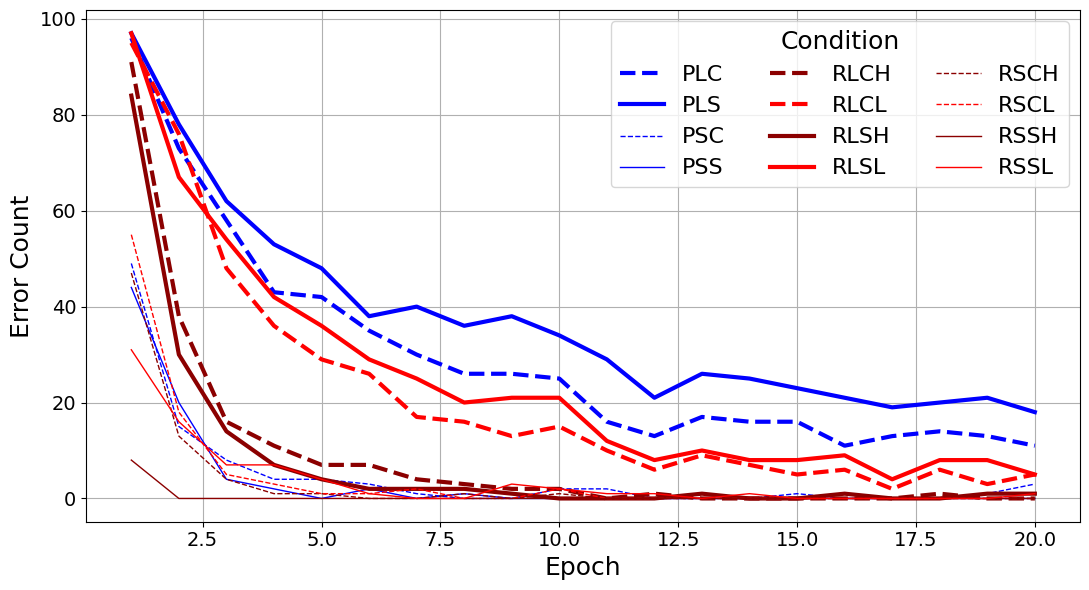

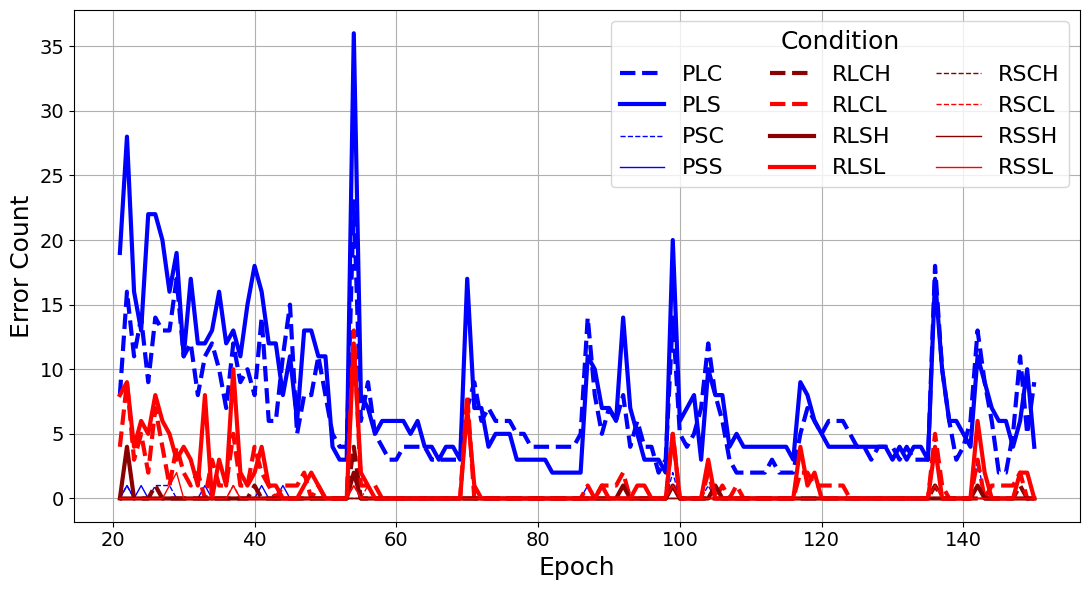

In [42]:
import matplotlib.pyplot as plt

df = pd.read_csv("../results/evaluation/Ua_LSTM_h128_l1_v42_d0.0_t0.0_s1~b2048_l0.001_fall_sn/development/dev_errors.csv", index_col=0)
conditions = df.columns.tolist()[1:]

# drop epochs with underscore
df = df[~df.epoch.str.contains("_")]
df.epoch = df.epoch.astype(int)
df = df.sort_values("epoch")

# separate epochs 1-20 and 21 onwards
df20 = df[df.epoch <= 20]
df150 = df[df.epoch > 20]

df20_long = pd.melt(
    df20,
    id_vars="epoch",
    value_vars=conditions,
    var_name="Condition",
    value_name="Value",
)

# Plotting each condition individually with custom properties
plt.figure(figsize=(11, 6))
for condition, group in df20_long.groupby("Condition"):
    plt.plot(
        group["epoch"],
        group["Value"],
        label=condition,
        color=get_color(condition),
        linestyle=get_linestyle(condition),
        linewidth=get_linewidth(condition),
    )

plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Error Count", fontsize=18)
plt.legend(title="Condition", fontsize=16, title_fontsize=18, ncol=3)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.grid(True)
plt.show()

df150_long = pd.melt(
    df150,
    id_vars="epoch",
    value_vars=conditions,
    var_name="Condition",
    value_name="Value",
)

plt.figure(figsize=(11, 6))
for condition, group in df150_long.groupby("Condition"):
    plt.plot(
        group["epoch"],
        group["Value"],
        label=condition,
        color=get_color(condition),
        linestyle=get_linestyle(condition),
        linewidth=get_linewidth(condition),
    )

plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Error Count", fontsize=18)
plt.legend(title="Condition", fontsize=16, title_fontsize=18, ncol=3)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.grid(True)
plt.show()


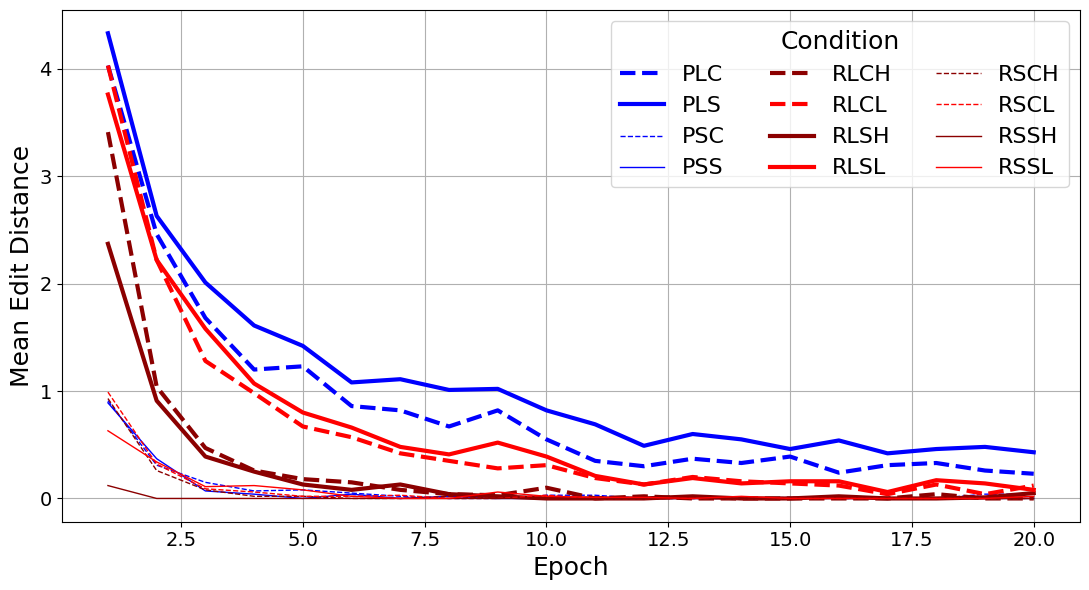

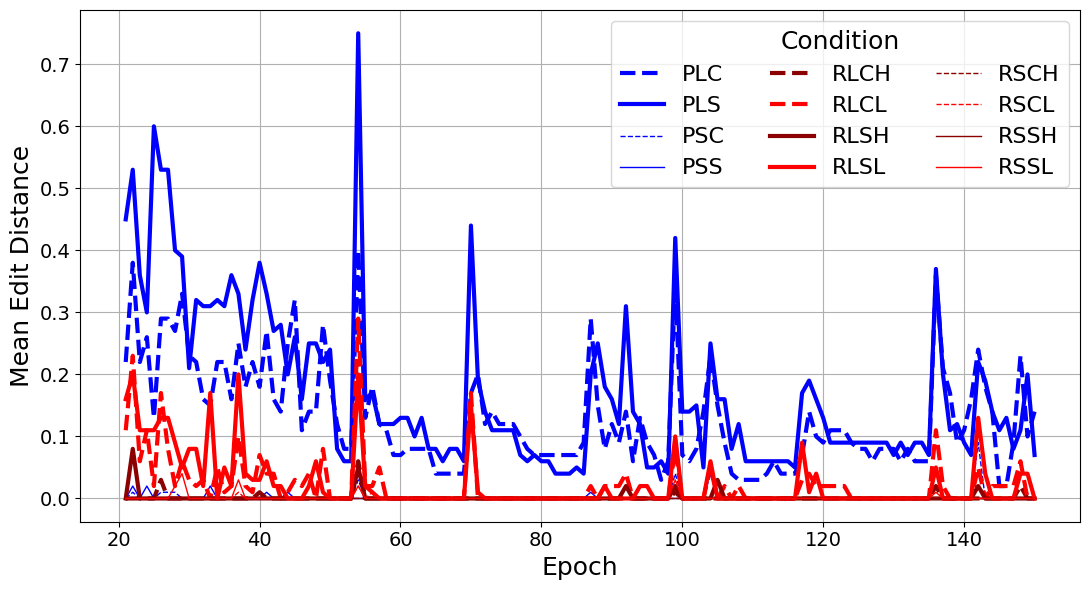

In [43]:
df = pd.read_csv("../results/evaluation/Ua_LSTM_h128_l1_v42_d0.0_t0.0_s1~b2048_l0.001_fall_sn/development/dev_edits.csv", index_col=0)
conditions = df.columns.tolist()[1:]

# drop epochs with underscore
df = df[~df.epoch.str.contains("_")]
df.epoch = df.epoch.astype(int)
df = df.sort_values("epoch")

# separate epochs 1-20 and 21 onwards
df20 = df[df.epoch <= 20]
df150 = df[df.epoch > 20]

df20_long = pd.melt(
    df20,
    id_vars="epoch",
    value_vars=conditions,
    var_name="Condition",
    value_name="Value",
)

# Plotting each condition individually with custom properties
plt.figure(figsize=(11, 6))
for condition, group in df20_long.groupby("Condition"):
    plt.plot(
        group["epoch"],
        group["Value"],
        label=condition,
        color=get_color(condition),
        linestyle=get_linestyle(condition),
        linewidth=get_linewidth(condition),
    )

plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Mean Edit Distance", fontsize=18)
plt.legend(title="Condition", fontsize=16, title_fontsize=18, ncol=3)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.grid(True)
plt.show()

df150_long = pd.melt(
    df150,
    id_vars="epoch",
    value_vars=conditions,
    var_name="Condition",
    value_name="Value",
)

plt.figure(figsize=(11, 6))
for condition, group in df150_long.groupby("Condition"):
    plt.plot(
        group["epoch"],
        group["Value"],
        label=condition,
        color=get_color(condition),
        linestyle=get_linestyle(condition),
        linewidth=get_linewidth(condition),
    )

plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Mean Edit Distance", fontsize=18)
plt.legend(title="Condition", fontsize=16, title_fontsize=18, ncol=3)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.grid(True)
plt.show()


In [ ]:
results = pd.read_csv(
    # "../results/test/Ua_LSTM_h128_l1_v42_d0.0_t0.0_s1~b2048_l0.001_fall_sn/75.csv",
    # "../results/ablations/Ua_LSTM_h128_l1_v42_d0.0_t0.0_s1~b2048_l0.001_fall_sn~75/encoder_49/75.csv",
    "../results/ablations/Ua_LSTM_h128_l1_v42_d0.0_t0.0_s1~b2048_l0.001_fall_sn~75/encoder_31/75.csv",
    # "../results/test/Ua_LSTM_h64_l1_v42_d0.0_t0.0_s1~b1024_l0.0005_fall_sn/108.csv",
    # "../results/ablations/Ua_LSTM_h64_l1_v42_d0.0_t0.0_s1~b1024_l0.0005_fall_sn~108/encoder_10/108.csv",
    converters=converters, 
    index_col=0
)

results = enrich_for_plotting(results, include_stress=False)

results.drop(columns=["Part of Speech", "Phonemes"], inplace=True)
print(100 - ((len(results[results["Edit Distance"] > 0])/1200 * 100)))
results[results["Edit Distance"] > 0]

### Generating Evaluation Dataset

In [ ]:
from ast import literal_eval

complete_train = pd.read_csv("../stimuli/dataframe/complete_train.csv")
complete_train["Lexicality"] = "real"
complete_train["Phonemes"] = complete_train["Phonemes"].apply(literal_eval)
complete_train["Length"] = complete_train["Phonemes"].apply(len)

# divide by length
short = complete_train.query("2 < Length < 6")
long = complete_train.query("6 < Length < 10")
short["Size"] = "short"
long["Size"] = "long"

# divide by frequency
lh = long[long["Zipf Frequency"] >= 4]
ll = long[long["Zipf Frequency"] <= 3.5]
sh = short[short["Zipf Frequency"] >= 4]
sl = short[short["Zipf Frequency"] <= 3.5]

# save files if necessary
# lh.to_csv("./long_high.csv", index=False)
# ll.to_csv("./long_low.csv", index=False)
# sh.to_csv("./short_high.csv", index=False)
# sl.to_csv("./short_low.csv", index=False)

In [ ]:
rlch = pd.read_csv("../stimuli/handmade/real/rlch.csv", index_col=0, converters=converters).sample(100)
rlcl = pd.read_csv("../stimuli/handmade/real/rlcl.csv", index_col=0, converters=converters).sample(100)
rlsh = pd.read_csv("../stimuli/handmade/real/rlsh.csv", index_col=0, converters=converters).sample(100)
rlsl = pd.read_csv("../stimuli/handmade/real/rlsl.csv", index_col=0, converters=converters).sample(100)
rsch = pd.read_csv("../stimuli/handmade/real/rsch.csv", index_col=0, converters=converters).sample(100)
rscl = pd.read_csv("../stimuli/handmade/real/rscl.csv", index_col=0, converters=converters).sample(100)
rssh = pd.read_csv("../stimuli/handmade/real/rssh.csv", index_col=0, converters=converters).sample(100)
rssl = pd.read_csv("../stimuli/handmade/real/rssl.csv", index_col=0, converters=converters).sample(100)
print(len(rlch), len(rlcl), len(rlsh), len(rlsl), len(rsch), len(rscl), len(rssh), len(rssl))

rlch["Condition"] = "RLCH"
rlch["Morphology"] = "complex"
rlcl["Condition"] = "RLCL"
rlcl["Morphology"] = "complex"
rlsh["Condition"] = "RLSH"
rlsh["Morphology"] = "simple"
rlsl["Condition"] = "RLSL"
rlsl["Morphology"] = "simple"
rsch["Condition"] = "RSCH"
rsch["Morphology"] = "complex"
rscl["Condition"] = "RSCL"
rscl["Morphology"] = "complex"
rssh["Condition"] = "RSSH"
rssh["Morphology"] = "simple"
rssl["Condition"] = "RSSL"
rssl["Morphology"] = "simple"

real_equalized = pd.concat([rlch, rlcl, rlsh, rlsl, rsch, rscl, rssh, rssl], ignore_index=True)
order = [
    "Word", "Condition", "Lexicality", "Size", "Morphology",
    "Frequency", "Length", "Zipf Frequency", "Phonemes",
    "No Stress", "Part of Speech"
]
real_equalized = real_equalized[order]
print(real_equalized["Condition"].value_counts())
real_equalized.to_csv("../stimuli/handmade/real_equalized.csv")

In [ ]:
psc3 = pd.read_csv("../stimuli/handmade/pseudo/psc3.csv", index_col=0, converters=converters)
psc4 = pd.read_csv("../stimuli/handmade/pseudo/psc4.csv", index_col=0, converters=converters).sample(46)
psc5 = pd.read_csv("../stimuli/handmade/pseudo/psc5.csv", index_col=0, converters=converters).sample(33)
plc7 = pd.read_csv("../stimuli/handmade/pseudo/plc7.csv", index_col=0, converters=converters).sample(33)
plc8 = pd.read_csv("../stimuli/handmade/pseudo/plc8.csv", index_col=0, converters=converters).sample(34)
plc9 = pd.read_csv("../stimuli/handmade/pseudo/plc9.csv", index_col=0, converters=converters).sample(33)
pss3 = pd.read_csv("../stimuli/handmade/pseudo/pss3.csv", index_col=0, converters=converters).sample(33)
pss4 = pd.read_csv("../stimuli/handmade/pseudo/pss4.csv", index_col=0, converters=converters).sample(34)
pss5 = pd.read_csv("../stimuli/handmade/pseudo/pss5.csv", index_col=0, converters=converters).sample(33)
pls7 = pd.read_csv("../stimuli/handmade/pseudo/pls7.csv", index_col=0, converters=converters).sample(33)
pls8 = pd.read_csv("../stimuli/handmade/pseudo/pls8.csv", index_col=0, converters=converters).sample(34)
pls9 = pd.read_csv("../stimuli/handmade/pseudo/pls9.csv", index_col=0, converters=converters).sample(33)

pseudo_equalized = pd.concat([pls9, psc3, psc4, psc5, plc7, plc8, plc9, pss3, pss4, pss5, pls7, pls8], ignore_index=True)
pseudo_equalized["Lexicality"] = "pseudo"
print(pseudo_equalized["Length"].value_counts())
print(pseudo_equalized["Condition"].value_counts())
order = [
    "Word", "Condition", "Lexicality", "Size", "Morphology",
    "Frequency", "Length", "Zipf Frequency", "Phonemes",
    "No Stress", "Part of Speech"
]
pseudo_equalized = pseudo_equalized[order]
pseudo_equalized.to_csv("../stimuli/handmade/pseudo_equalized.csv")

In [ ]:
test_equalized = pd.concat([real_equalized, pseudo_equalized])
print(test_equalized["Condition"].value_counts())
test_equalized.to_csv("../stimuli/handmade/test_equalized.csv")
test_equalized

### Processing Pseudo Words

In [ ]:
from ast import literal_eval
from g2p_en import G2p
g2p = G2p()

def remove_stress(phonemes):
    return [p[:-1] if p[-1].isdigit() else p for p in phonemes]

converters = {"Word": str, "Phonemes": literal_eval, "No Stress": literal_eval}

complete_train = pd.read_csv("../stimuli/dataframe/complete_train.csv", index_col=0, converters=converters)
raw_pseudo = pd.read_csv("../stimuli/handmade/pseudo/raw_pseudo.csv", index_col=0, converters=converters)

# filter out all words that are in the train set
raw_pseudo = raw_pseudo[~raw_pseudo["Word"].isin(complete_train["Word"])]
raw_pseudo["Phonemes"] = raw_pseudo["Word"].apply(g2p)
raw_pseudo["No Stress"] = raw_pseudo["Phonemes"].apply(remove_stress)
raw_pseudo["Length"] = raw_pseudo["Phonemes"].apply(len)
raw_pseudo = raw_pseudo.query("1 < Length < 11")
raw_pseudo.to_csv("../stimuli/handmade/pseudo/raw_pseudo.csv")
print(len(raw_pseudo))

In [ ]:
import pandas as pd
from Levenshtein import distance

def compute_min_distances(dfA, dfB):
    """
      - Compute the minimum Levenshtein distance to any row in dfB (by Word)
      - Compute the minimum Levenshtein distance to any row in dfB (by Phonemes)
      - Normalize each of those distances by the length of Word or length of the Phonemes list
    """
    dfA["characterDist"] = dfA["Word"].apply(
        lambda w_a: min(distance(w_a, w_b) for w_b in dfB["Word"]) / len(w_a)
    )
    dfA["phonemeDist"] = dfA["Phonemes"].apply(
        lambda ph_a: min(distance(ph_a, ph_b) for ph_b in dfB["Phonemes"]) / len(ph_a)
    )
    return dfA

def filter_by_distance(dfA, threshold):
    return dfA[(dfA["characterDist"] >= threshold) & (dfA["phonemeDist"] >= threshold)]

raw_pseudo = compute_min_distances(raw_pseudo, complete_train)
pseudo_complete = filter_by_distance(raw_pseudo, threshold=0.25)
print(pseudo_complete["Length"].value_counts())

pseudo_complete[pseudo_complete["Length"] == 3].to_csv("3.csv")
pseudo_complete[pseudo_complete["Length"] == 4].to_csv("4.csv")
pseudo_complete[pseudo_complete["Length"] == 5].to_csv("5.csv")
pseudo_complete[pseudo_complete["Length"] == 6].to_csv("6.csv")
pseudo_complete[pseudo_complete["Length"] == 7].to_csv("7.csv")
pseudo_complete[pseudo_complete["Length"] == 8].to_csv("8.csv")
pseudo_complete[pseudo_complete["Length"] == 9].to_csv("9.csv")

In [ ]:
plc = pd.read_csv("../stimuli/handmade/test_data/plc.csv", index_col=0, converters=converters)
pls = pd.read_csv("../stimuli/handmade/test_data/pls.csv", index_col=0, converters=converters)
psc = pd.read_csv("../stimuli/handmade/test_data/psc.csv", index_col=0, converters=converters)
pss = pd.read_csv("../stimuli/handmade/test_data/pss.csv", index_col=0, converters=converters)

print(plc["Length"].value_counts())
print(pls["Length"].value_counts())
print(psc["Length"].value_counts())
print(pss["Length"].value_counts())